In [42]:
import warnings
warnings.filterwarnings('ignore')

Import libraries

In [43]:
# Import libraries

import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import missingno
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [44]:
# Read data
name = pd.read_excel("/content/short_data.xlsx", sheet_name="Name", index_col=0)     # 8208 cells
public_date = pd.read_excel("/content/short_data.xlsx", sheet_name="Public Date", index_col=0, parse_dates=True)     
ocf = pd.read_excel("/content/short_data.xlsx", sheet_name="OCF", index_col=0)   # 1113 missing values   86%
roa = pd.read_excel("/content/short_data.xlsx", sheet_name="ROA", index_col=0)   # 1424    83%
ta = pd.read_excel("/content/short_data.xlsx", sheet_name="TA", index_col=0)   # 1115   86%
mv = pd.read_excel("/content/short_data.xlsx", sheet_name="MV", index_col=0)   # 1795    78%
total_lia = pd.read_excel("/content/short_data.xlsx", sheet_name="Total Lia", index_col=0)    # 1114    86%
sales = pd.read_excel("/content/short_data.xlsx", sheet_name="Sales", index_col=0)   # 1104    87%
tangible_FA = pd.read_excel("/content/short_data.xlsx", sheet_name="Tangible FA", index_col=0)   # 1124    86%
total_ca = pd.read_excel("/content/short_data.xlsx", sheet_name="Total CA", index_col=0)   # 1114    86%
current_lia = pd.read_excel("/content/short_data.xlsx", sheet_name="Total Current Lia", index_col=0)   # 1114    86%
fixed_assets = pd.read_excel("/content/short_data.xlsx", sheet_name="Fixed assets", index_col=0)
accounts_receivable = pd.read_excel("/content/short_data.xlsx", sheet_name="Accounts Receivable", index_col=0)
costs_of_revenue = pd.read_excel("/content/short_data.xlsx", sheet_name="Costs of revenue", index_col=0)
ebit = pd.read_excel("/content/short_data.xlsx", sheet_name="EBIT", index_col=0)
eps = pd.read_excel("/content/short_data.xlsx", sheet_name="EPS", index_col=0)
equity = pd.read_excel("/content/short_data.xlsx", sheet_name="Equity", index_col=0)
avg_receivable_days = pd.read_excel("/content/short_data.xlsx", sheet_name="Avg. Receivable days", index_col=0)
avg_payable_days = pd.read_excel("/content/short_data.xlsx", sheet_name="Avg. Payable days", index_col=0)
avg_inventory_days = pd.read_excel("/content/short_data.xlsx", sheet_name="Avg. Inventory days", index_col=0)

# Biến vĩ mô
gdp = pd.read_excel("/content/short_data.xlsx", sheet_name="GDP", index_col=0)
cpi = pd.read_excel("/content/short_data.xlsx", sheet_name="CPI", index_col=0)
interest_rates = pd.read_excel("/content/short_data.xlsx", sheet_name="Interest rates", index_col=0)

Drop companies are established under 5 years

In [45]:
# Drop companies are established under 5 years
com_under5years = []
for i in name.index:
  if int(public_date.loc[i,'Date Became Public'].strftime('%Y')) > 2015:
    com_under5years.append(i)      
print(len(com_under5years))  # 168 companies are established under 5 years.

name.drop(com_under5years,axis='index', inplace=True)   # 516 remained companies
ocf.drop(com_under5years,axis='columns', inplace=True)
roa.drop(com_under5years,axis='columns', inplace=True)
ta.drop(com_under5years,axis='columns', inplace=True)
mv.drop(com_under5years,axis='columns', inplace=True)
total_lia.drop(com_under5years,axis='columns', inplace=True)
sales.drop(com_under5years,axis='columns', inplace=True)
tangible_FA.drop(com_under5years,axis='columns', inplace=True)
total_ca.drop(com_under5years,axis='columns', inplace=True)
current_lia.drop(com_under5years,axis='columns', inplace=True)
fixed_assets.drop(com_under5years,axis='columns', inplace=True)
accounts_receivable.drop(com_under5years,axis='columns', inplace=True)
costs_of_revenue.drop(com_under5years,axis='columns', inplace=True)
ebit.drop(com_under5years,axis='columns', inplace=True)
eps.drop(com_under5years,axis='columns', inplace=True)
equity.drop(com_under5years,axis='columns', inplace=True)
avg_receivable_days.drop(com_under5years,axis='columns', inplace=True)
avg_payable_days.drop(com_under5years,axis='columns', inplace=True)
avg_inventory_days.drop(com_under5years,axis='columns', inplace=True)
gdp.drop(com_under5years,axis='columns', inplace=True)
cpi.drop(com_under5years,axis='columns', inplace=True)
interest_rates.drop(com_under5years,axis='columns', inplace=True)
public_date = public_date.loc[name.index, :]

public_date.shape # (516, 2) --> 516 remained companies

168


(516, 2)

Biến X: Growth, Size, Age, Liq, Lev, PPE, Quick ratio, Inv turnover ratio, FA turnover ratio, TA turnover ratio, DSO, Capital intensity, Expense revenue ratio, Operating margin, Net profit margin, BEP, ROA, ROE, EPS, CCC.

Biến Y: ni > 0, ocf > 0

Fill Equity, FA, EBIT, cost of revenue, A.R

In [46]:
# Fill Avg. Inventory days: For the time-series dataset variable, it makes sense to use the interpolation of the variable before and after a timestamp for a missing value.

avg_inventory_days = avg_inventory_days.interpolate(method='linear', limit_direction='both', axis=0)
print(avg_inventory_days.isnull().sum().sum())   # 48 (VNF.HN, VNT.HN, VNL.HM, TVC.HN bị NaN nguyên cột)

# Fill Avg. Payable days

avg_payable_days = avg_payable_days.interpolate(method='linear', limit_direction='both', axis=0)
print(avg_payable_days.isnull().sum().sum())   # 0

# Fill Avg. Receivable days

avg_receivable_days = avg_receivable_days.interpolate(method='linear', limit_direction='both', axis=0)
print(avg_receivable_days.isnull().sum().sum())  # 0

# Fill Equity

equity = equity.interpolate(method='linear', limit_direction='both', axis=0)
print(equity.isnull().sum().sum()) 

# Fill Fixed Assets

fixed_assets = fixed_assets.interpolate(method='linear', limit_direction='both', axis=0)
print(fixed_assets.isnull().sum().sum()) 

# Fill EBIT

ebit = ebit.interpolate(method='linear', limit_direction='both', axis=0)
print(ebit.isnull().sum().sum()) 

# Fill cost of revenue

costs_of_revenue = costs_of_revenue.interpolate(method='linear', limit_direction='both', axis=0)
print(costs_of_revenue.isnull().sum().sum()) 

# Fill A.R

accounts_receivable = accounts_receivable.interpolate(method='linear', limit_direction='both', axis=0)
print(accounts_receivable.isnull().sum().sum()) 


48
0
0
0
0
0
0
0


Detect columns having missing values

In [47]:
def detect_nan(data):
  nan_values = data.isna()
  nan_columns = nan_values.any()
  columns_with_nan = data.columns[nan_columns].tolist()
  return (columns_with_nan)

In [48]:
detect_nan(avg_inventory_days)

# Because these 4 columns will assurantly be dropped in the next step, we do not fill avg_inventory_days.

['VNF.HN', 'TVC.HN', 'VNT.HN', 'VNL.HM']

Convert negative values to positive values in column Cost of revenue, A.R, Avg.Inv days, Avg. Receivable days, Avg. Payable days.



In [49]:
# Function converts negative values to positive

def fix_negative(data):
  for j in range(data.shape[1]):
    for i in range(data.shape[0]):
      if data.iloc[i,j] < 0:
        data.iloc[i,j] = 0-data.iloc[i,j]
fix_negative(costs_of_revenue)
fix_negative(accounts_receivable)
fix_negative(avg_inventory_days)
fix_negative(avg_receivable_days)
fix_negative(avg_payable_days)

Calculate variables

In [50]:
# Calculate NI
ni = roa * ta

# Calculate Size
size = np.log(mv)

# Calculate Leverage
lev = total_lia / ta

# Calculate PPE
ppe = tangible_FA / sales

# Calculate Liquidity
liq = total_ca / current_lia

# Calculate Growth                                            (based on 2010-2020)
growth = sales.pct_change(periods=1)
growth.drop(growth.index[0], axis='index', inplace=True)

# Calculate Inv turnover ratio
inv_turnover = 365 / avg_inventory_days

# Calculate Inv
inv = sales/inv_turnover

# Calculate Quick ratio
quick = (total_ca - inv) / current_lia

# Calculate FA turnover ratio 
fa_turnover = sales / fixed_assets

# Calculate TA turnover ratio 
ta_turnover = sales / ta

# Calculate DSO
dso = accounts_receivable / (sales / 365)

# Calculate Capital intensity
capital_intensity = ta / sales

# Calculate Expense revenue ratio
expense_revenue = costs_of_revenue / sales

# Calculate Operating margin
operating_margin = ebit / sales

# Calculate Net profit margin
net_profit_margin = ni / sales

# Calculate BEP
bep = ebit / ta

# Calculate ROE
roe = ni / equity

# Calculate growth of CCC
ccc = avg_inventory_days + avg_receivable_days - avg_payable_days


Drop year 2009

In [51]:
# Drop year 2009
ni.drop(ni.index[0], axis='index', inplace=True)   
ocf.drop(ocf.index[0], axis='index', inplace=True)   
size.drop(size.index[0], axis='index', inplace=True)   
lev.drop(lev.index[0], axis='index', inplace=True)   
ppe.drop(ppe.index[0], axis='index', inplace=True)   
liq.drop(liq.index[0], axis='index', inplace=True)  
inv_turnover.drop(inv_turnover.index[0], axis='index', inplace=True) 
quick.drop(quick.index[0], axis='index', inplace=True) 
fa_turnover.drop(fa_turnover.index[0], axis='index', inplace=True) 
ta_turnover.drop(ta_turnover.index[0], axis='index', inplace=True) 
dso.drop(dso.index[0], axis='index', inplace=True) 
capital_intensity.drop(capital_intensity.index[0], axis='index', inplace=True) 
expense_revenue.drop(expense_revenue.index[0], axis='index', inplace=True) 
operating_margin.drop(operating_margin.index[0], axis='index', inplace=True) 
net_profit_margin.drop(net_profit_margin.index[0], axis='index', inplace=True) 
bep.drop(bep.index[0], axis='index', inplace=True) 
roe.drop(roe.index[0], axis='index', inplace=True) 
roa.drop(roa.index[0], axis='index', inplace=True) 
eps.drop(eps.index[0], axis='index', inplace=True) 
ccc.drop(ccc.index[0], axis='index', inplace=True) 
gdp.drop(gdp.index[0], axis='index', inplace=True)  
cpi.drop(cpi.index[0], axis='index', inplace=True)  
interest_rates.drop(interest_rates.index[0], axis='index', inplace=True)

Calculate 'Age' variable

In [52]:
# Calculate Age of companies
ind = list(range(2010, 2021))
col = size.columns
age = pd.DataFrame(columns=size.columns)

for i in ind:
  list_year = []
  for j in size.columns:
    num = i - public_date.loc[j,'Organization Founded Year']
    list_year.append(num)
  age_length = len(age)
  age.loc[age_length] = list_year
age.index = size.index

# Các công ty thành lập sau năm 2010 được thay thế age bằng np.nan nếu age bị âm.
age = age.replace(list(range(-5,0)), np.NaN)

Query Current asset values are less than Inventory values and sum.

In [53]:
cols=[]
for j in range(len(total_ca.columns)):
  for i in range(len(total_ca.index)):
    if total_ca.iloc[i,j] < inv.iloc[i,j]:
      cols.append(total_ca.columns[j])
      break
print(len(cols))

182


Query EBIT values are higher than Sale values

In [54]:
cols=[]
for j in range(len(ebit.columns)):
  for i in range(len(ebit.index)):
    if sales.iloc[i,j] < ebit.iloc[i,j]:
      cols.append(ebit.columns[j])
      break
print(len(cols))

90


Query NI values are higher than Sale values

In [55]:
cols=[]
for j in range(len(ni.columns)):
  for i in range(len(ni.index)):
    if sales.iloc[i,j] < ni.iloc[i,j]:
      cols.append(ni.columns[j])
      break
print(len(cols))

62


In [56]:
# NI > 0 & OCF > 0 --> Nhóm profit (có lợi nhuận ròng và dòng tiền dương từ hoạt động kd)
# NI<= 0 & OCF <= 0 --> Nhóm loss (không có lợi nhuận từ hđkd)

target = pd.DataFrame(np.random.randn(11, 516), columns=size.columns, index = size.index)
for i in range(len(size.index)):
  for j in range(len(size.columns)):
    if ni.iloc[i,j] > 0 and ocf.iloc[i,j] > 0:
      target.iloc[i,j] = 1
    else:
      target.iloc[i,j] = 0
print(target.to_string())

      CHP.HM  POM.HM  V21.HN  LIG.HN  MCC.HN  TET.HN  KSD.HN  TDC.HM  OGC.HM  HTC.HN  NVT.HM  VCM.HN  SPM.HM  CX8.HN  TNT.HM  HU1.HM  SBA.HM  IDV.HN  AME.HN  PXS.HM  DTL.HM  PDN.HM  VXB.HN  PXI.HM  NNC.HM  DLG.HM  CMV.HM  VE3.HN  BCE.HM  UDC.HM  DC2.HN  LCS.HN  DTA.HM  AAA.HM  LDP.HN  DRH.HM  SMT.HN  HHG.HN  VRC.HM  VE2.HN  HMH.HN  PDR.HM  VLA.HN  PCT.HN  CVN.HN  QCG.HM  MIM.HN  WCS.HN  NET.HN  IDJ.HN  VOS.HM  SHP.HM  PTL.HM  HVX.HM  VMD.HM  OCH.HN  APP.HN  HAT.HN  TIG.HN  C32.HM  SMA.HM  ELC.HM  DSN.HM  HQC.HM  TDW.HM  ARM.HN  KTT.HN  LM7.HN  SCR.HM  CMX.HM  LM8.HM  LCD.HN  PRC.HN  CMS.HN  VNF.HN  VKC.HN  EVE.HM  VAT.HN  PV2.HN  HTI.HM  VSI.HM  ADC.HN  HDA.HN  PCG.HN  KST.HN  KTS.HN  BSC.HN  PPS.HN  HTL.HM  CLW.HM  TVD.HN  MDG.HM  PTD.HN  NKG.HM  TSB.HN  VCF.HM  MCF.HN  DNM.HN  D11.HN  CCL.HM  HU3.HM  C47.HM  DIH.HN  NDN.HN  VIE.HN  IDI.HM  JVC.HM  PTB.HM  CIG.HM  INC.HN  THG.HM  HOT.HM  SVN.HN  L14.HN  GMX.HN  SVT.HM  LCM.HM  PPE.HN  FLC.HM  CNG.HM  BRC.HM  HHS.HM  GSP.HM  AMC.HN  LA

Count values in each case.

In [57]:
pd.Series(target.values.flatten()).value_counts()

1.0    3549
0.0    2127
dtype: int64

Merge all variables into a dataframe named 'Data' by columns

In [58]:
data = pd.DataFrame()
data['Size'] = size.values.flatten()
data['Leverage'] = lev.values.flatten()
data['Growth'] = growth.values.flatten()
data['PPE'] = ppe.values.flatten()
data['Liquidity'] = liq.values.flatten()
data['Age'] = age.values.flatten()
data['Quick ratio'] = quick.values.flatten()
data['Inventory turnover ratio'] = inv_turnover.values.flatten()
data['FA turnover ratio'] = fa_turnover.values.flatten()
data['TA turnover ratio'] = ta_turnover.values.flatten()
data['DSO'] = dso.values.flatten()
data['Capital intensity'] = capital_intensity.values.flatten()
data['Expense of revenue ratio'] = expense_revenue.values.flatten()
data['Operating margin'] = operating_margin.values.flatten()
data['Net profit margin'] = net_profit_margin.values.flatten()
data['ROA'] = roa.values.flatten()
data['ROE'] = roe.values.flatten()
data['EPS'] = eps.values.flatten()
data['BEP'] = bep.values.flatten()
data['CCC'] = ccc.values.flatten()
data['GDP'] = gdp.values.flatten()
data['CPI'] = cpi.values.flatten()
data['Interest rates'] = interest_rates.values.flatten()
data['Target'] = target.values.flatten()

# Set up multi index
year = np.arange(2010,2021)
com = list(size.columns)

index = pd.MultiIndex.from_product([year, com],
                           names=['Year', 'Company'])
data.index = index
print(data.shape)   # (5676, 24) --> 5676 observations, 23 independent variables, 1 target column
data

(5676, 24)


Size  Leverage    Growth       PPE  Liquidity   Age  \
Year Company                                                             
2010 CHP.HM   26.811996  0.526188       NaN       NaN   5.263539   6.0   
     POM.HM   29.308265  0.631919  0.485906  0.161338   1.399731  11.0   
     V21.HN   24.511991  0.909509  0.728948  0.044329   1.194372   5.0   
     LIG.HN   26.171438  0.810075  0.669013  0.281770   1.406351  14.0   
     MCC.HN   25.514182  0.071271  0.189628  0.244802   5.807324   4.0   
...                 ...       ...       ...       ...        ...   ...   
2020 DAG.HM   26.623564  0.610937  0.074296  0.402745   1.166272  19.0   
     PVL.HN   25.277143  0.410206  0.589727  1.957516   0.909948  13.0   
     CCI.HM   26.508283  0.602509 -0.244980  0.171636  11.352394  28.0   
     PPP.HN   25.322819  0.256210 -0.226251  0.588233   1.761310  20.0   
     IJC.HM   28.842630  0.688299  0.338464  0.440331   1.481065  13.0   

              Quick ratio  Inventory turnover ratio  FA turnover ratio  \
Year Company                                                             
2010 CHP.HM           NaN                 36.590461                NaN   
     POM.HM      0.717048                  4.051764           2.270428   
     V21.HN      0.274740                  1.559963          19.697700   
     LIG.HN      0.945083                  3.843361           0.512498   
     MCC.HN      4.116953                  6.262846          10.374847   
...                   ...                       ...                ...   
2020 DAG.HM      0.447435                  2.871849          15.073621   
     PVL.HN      0.874132                  3.989148           0.574304   
     CCI.HM     10.813581                 20.879260           3.837863   
     PPP.HN      1.307953                  8.275423           3.926553   
     IJC.HM      0.786886                  0.968705           3.538940   

              TA turnover ratio          DSO  Capital intensity  \
Year Company                                                      
2010 CHP.HM                 NaN          NaN                NaN   
     POM.HM            1.461675    97.303558           0.684146   
     V21.HN            1.132611    85.475842           0.882916   
     LIG.HN            0.895913   528.605058           1.116179   
     MCC.HN            0.733156    10.894706           1.363966   
...                         ...          ...                ...   
2020 DAG.HM            1.009896    14.679956           0.990201   
     PVL.HN            0.058207  1056.801314          17.180152   
     CCI.HM            0.419079    14.687985           2.386182   
     PPP.HN            0.808258    17.741317           1.237228   
     IJC.HM            0.322399    47.796188           3.101750   

              Expense of revenue ratio  Operating margin  Net profit margin  \
Year Company                                                                  
2010 CHP.HM                        NaN               NaN                NaN   
     POM.HM                   1.052063          0.005026           0.066280   
     V21.HN                   0.658292          0.037879           0.023508   
     LIG.HN                   2.505594          0.162164           0.055030   
     MCC.HN                   1.694083          0.187835           0.238117   
...                                ...               ...                ...   
2020 DAG.HM                   0.091568          0.017150           0.005769   
     PVL.HN                   1.822281          0.764657           0.027878   
     CCI.HM                   0.489455          0.034389           0.103947   
     PPP.HN                   0.381667          0.010540           0.079802   
     IJC.HM                   0.033609          0.063179           0.161416   

                   ROA       ROE         EPS       BEP         CCC       GDP  \
Year Company                                                                   
2010 CHP.HM   0.000000  0.000000 

Check types of columns

In [59]:
data.dtypes

Size                        float64
Leverage                    float64
Growth                      float64
PPE                         float64
Liquidity                   float64
Age                         float64
Quick ratio                 float64
Inventory turnover ratio    float64
FA turnover ratio           float64
TA turnover ratio           float64
DSO                         float64
Capital intensity           float64
Expense of revenue ratio    float64
Operating margin            float64
Net profit margin           float64
ROA                         float64
ROE                         float64
EPS                         float64
BEP                         float64
CCC                         float64
GDP                         float64
CPI                         float64
Interest rates              float64
Target                      float64
dtype: object

Describe data

In [60]:
data.describe()

,Size,Leverage,Growth,PPE,Liquidity,Age,Quick ratio,Inventory turnover ratio,FA turnover ratio,TA turnover ratio,DSO,Capital intensity,Expense of revenue ratio,Operating margin,Net profit margin,ROA,ROE,EPS,BEP,CCC,GDP,CPI,Interest rates,Target
count,5349.000000,5500.000000,5422.000000,5478.000000,5500.000000,5671.000000,5447.000000,5.632000e+03,5493.000000,5488.000000,5493.000000,5488.000000,5493.000000,5493.000000,5389.000000,5401.000000,5401.000000,5424.000000,5500.000000,5632.000000,5676.000000,5676.000000,5676.000000,5676.000000
mean,26.206681,0.503325,0.819063,1.344652,2.494280,14.539058,1.143721,3.316749e+03,187.578037,1.208536,425.219977,5.878071,2.086003,0.084221,0.073403,0.063025,0.245847,1751.246467,0.092343,607.035918,6.001623,5.821202,3.797918,0.625264
std,1.706232,0.220097,28.846328,26.900571,5.747591,8.030378,10.814115,1.262056e+05,5163.828023,1.208844,3921.039985,80.061323,20.197749,7.499365,2.228670,0.081622,3.018882,2237.747674,0.252319,8576.232873,1.131059,4.809275,2.944192,0.484097
min,21.716518,0.001981,-0.997369,0.000000,0.097129,0.000000,-417.966836,2.441213e-03,0.000916,0.000257,0.000000,0.078533,0.000000,-508.681825,-53.557106,-0.787392,-120.008465,-11820.461130,-10.587992,-40612.961510,2.905836,0.631201,-3.551709,0.000000
25%,25.040748,0.339080,-0.089543,0.069949,1.124654,9.000000,0.496845,2.473381e+00,1.914813,0.464491,26.725062,0.640350,0.453810,0.023277,0.017170,0.015613,0.041223,515.256803,0.022247,50.453632,5.421883,2.795824,2.294892,0.000000
50%,26.061765,0.525305,0.071820,0.188784,1.505083,13.000000,0.898045,4.971114e+00,6.022258,0.919167,63.735184,1.087942,0.773390,0.060170,0.046602,0.048124,0.112584,1367.377280,0.058002,114.445307,6.240303,3.539628,4.825874,1.000000
75%,27.231882,0.676313,0.239977,0.479205,2.410178,19.000000,1.564948,1.171522e+01,17.069339,1.561646,158.891812,2.152895,1.170790,0.141389,0.110268,0.093865,0.216295,2485.573435,0.114819,225.237739,6.812246,9.094703,5.814896,1.000000
max,33.590443,1.208426,2090.388236,1799.095323,242.577244,60.000000,242.109751,8.775515e+06,227955.634155,12.733542,141151.614759,3896.165086,744.019267,180.603577,122.490907,0.839056,162.338138,25717.077680,7.906537,516652.621870,7.075789,18.677732,7.322258,1.000000


Visualize values' distribution in each column.

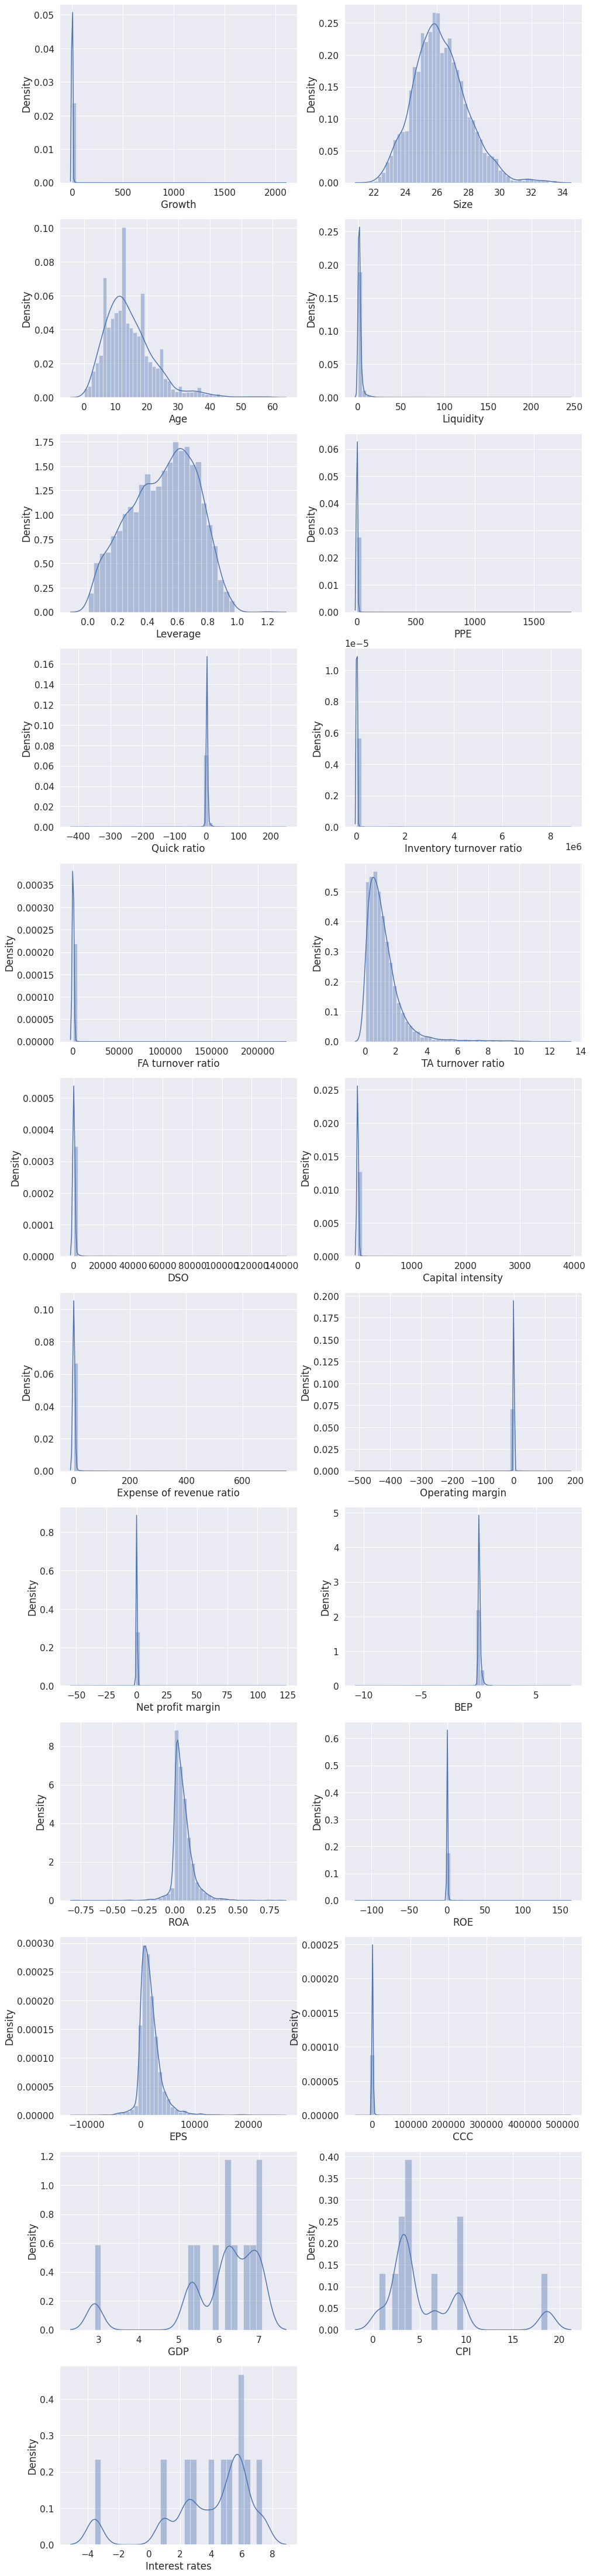

In [61]:

plt.figure(figsize=(16,80))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(12,2,x)
    sns.distplot(data[i])
    x+=1
  plt.show()

density(['Growth', 'Size', 'Age', 'Liquidity', 'Leverage', 'PPE', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'TA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'BEP', 'ROA', 'ROE', 'EPS', 'CCC', 'GDP', 'CPI', 'Interest rates'])

Deal with outliers

In [62]:
def highest_lowest(list_variables):
  for i in list_variables:
    print(f"Highest allowed of {i}",data[i].mean() + 3*data[i].std())
    print(f"Lowest allowed of {i}",data[i].mean() - 3*data[i].std())
    print('---------')

highest_lowest(['Growth', 'PPE', 'Liquidity', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'ROE', 'CCC'])

Highest allowed of Growth 87.35804716717797
Lowest allowed of Growth -85.71992184748268
---------
Highest allowed of PPE 82.04636374491612
Lowest allowed of PPE -79.35705977610665
---------
Highest allowed of Liquidity 19.737054006355354
Lowest allowed of Liquidity -14.748494586037717
---------
Highest allowed of Quick ratio 33.5860660350548
Lowest allowed of Quick ratio -31.298623503346448
---------
Highest allowed of Inventory turnover ratio 381933.4000469356
Lowest allowed of Inventory turnover ratio -375299.902203188
---------
Highest allowed of FA turnover ratio 15679.062104736446
Lowest allowed of FA turnover ratio -15303.90603155603
---------
Highest allowed of DSO 12188.339931365663
Lowest allowed of DSO -11337.89997835111
---------
Highest allowed of Capital intensity 246.06203998924704
Lowest allowed of Capital intensity -234.30589881763902
---------
Highest allowed of Expense of revenue ratio 62.67924952519992
Lowest allowed of Expense of revenue ratio -58.507243762300746
--

In [63]:
name = ['Growth', 'PPE', 'Liquidity', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'ROE', 'CCC']
def capping(df):
  upper_limit = df[name].mean() + 3*df[name].std()
  lower_limit = df[name].mean() - 3*df[name].std()
  for i in name:
    df[name] = np.where(
      df[name]>upper_limit,
      upper_limit,
      np.where(
          df[name]<lower_limit,
          lower_limit,
          df[name]
      )
  )

capping(data)
data.describe()

,Size,Leverage,Growth,PPE,Liquidity,Age,Quick ratio,Inventory turnover ratio,FA turnover ratio,TA turnover ratio,DSO,Capital intensity,Expense of revenue ratio,Operating margin,Net profit margin,ROA,ROE,EPS,BEP,CCC,GDP,CPI,Interest rates,Target
count,5349.000000,5500.000000,5422.000000,5478.000000,5500.000000,5671.000000,5447.000000,5632.000000,5493.000000,5488.000000,5493.000000,5488.000000,5493.000000,5493.000000,5389.000000,5401.000000,5401.000000,5424.000000,5500.000000,5632.000000,5676.000000,5676.000000,5676.000000,5676.000000
mean,26.206681,0.503325,0.394154,0.805668,2.322255,14.539058,1.322715,859.604250,60.869434,1.208536,270.502417,3.561490,1.431539,0.156534,0.076003,0.063025,0.216005,1751.246467,0.092343,381.484782,6.001623,5.821202,3.797918,0.625264
std,1.706232,0.220097,3.452518,3.953259,2.593976,8.030378,3.531191,15613.972332,550.442808,1.208844,1073.990343,16.194301,4.363704,1.286881,0.508483,0.081622,0.641309,2237.747674,0.252319,1876.425356,1.131059,4.809275,2.944192,0.484097
min,21.716518,0.001981,-0.997369,0.000000,0.097129,0.000000,-31.298624,0.002441,0.000916,0.000257,0.000000,0.078533,0.000000,-22.413873,-6.612608,-0.787392,-8.810799,-11820.461130,-10.587992,-25121.662701,2.905836,0.631201,-3.551709,0.000000
25%,25.040748,0.339080,-0.089543,0.069949,1.124654,9.000000,0.496845,2.473381,1.914813,0.464491,26.725062,0.640350,0.453810,0.023277,0.017170,0.015613,0.041223,515.256803,0.022247,50.453632,5.421883,2.795824,2.294892,0.000000
50%,26.061765,0.525305,0.071820,0.188784,1.505083,13.000000,0.898045,4.971114,6.022258,0.919167,63.735184,1.087942,0.773390,0.060170,0.046602,0.048124,0.112584,1367.377280,0.058002,114.445307,6.240303,3.539628,4.825874,1.000000
75%,27.231882,0.676313,0.239977,0.479205,2.410178,19.000000,1.564948,11.715217,17.069339,1.561646,158.891812,2.152895,1.170790,0.141389,0.110268,0.093865,0.216295,2485.573435,0.114819,225.237739,6.812246,9.094703,5.814896,1.000000
max,33.590443,1.208426,87.358047,82.046364,19.737054,60.000000,33.586066,381933.400047,15679.062105,12.733542,12188.339931,246.062040,62.679250,22.582316,6.759415,0.839056,9.302494,25717.077680,7.906537,26335.734538,7.075789,18.677732,7.322258,1.000000


Re-visualize values' distribution in each column.

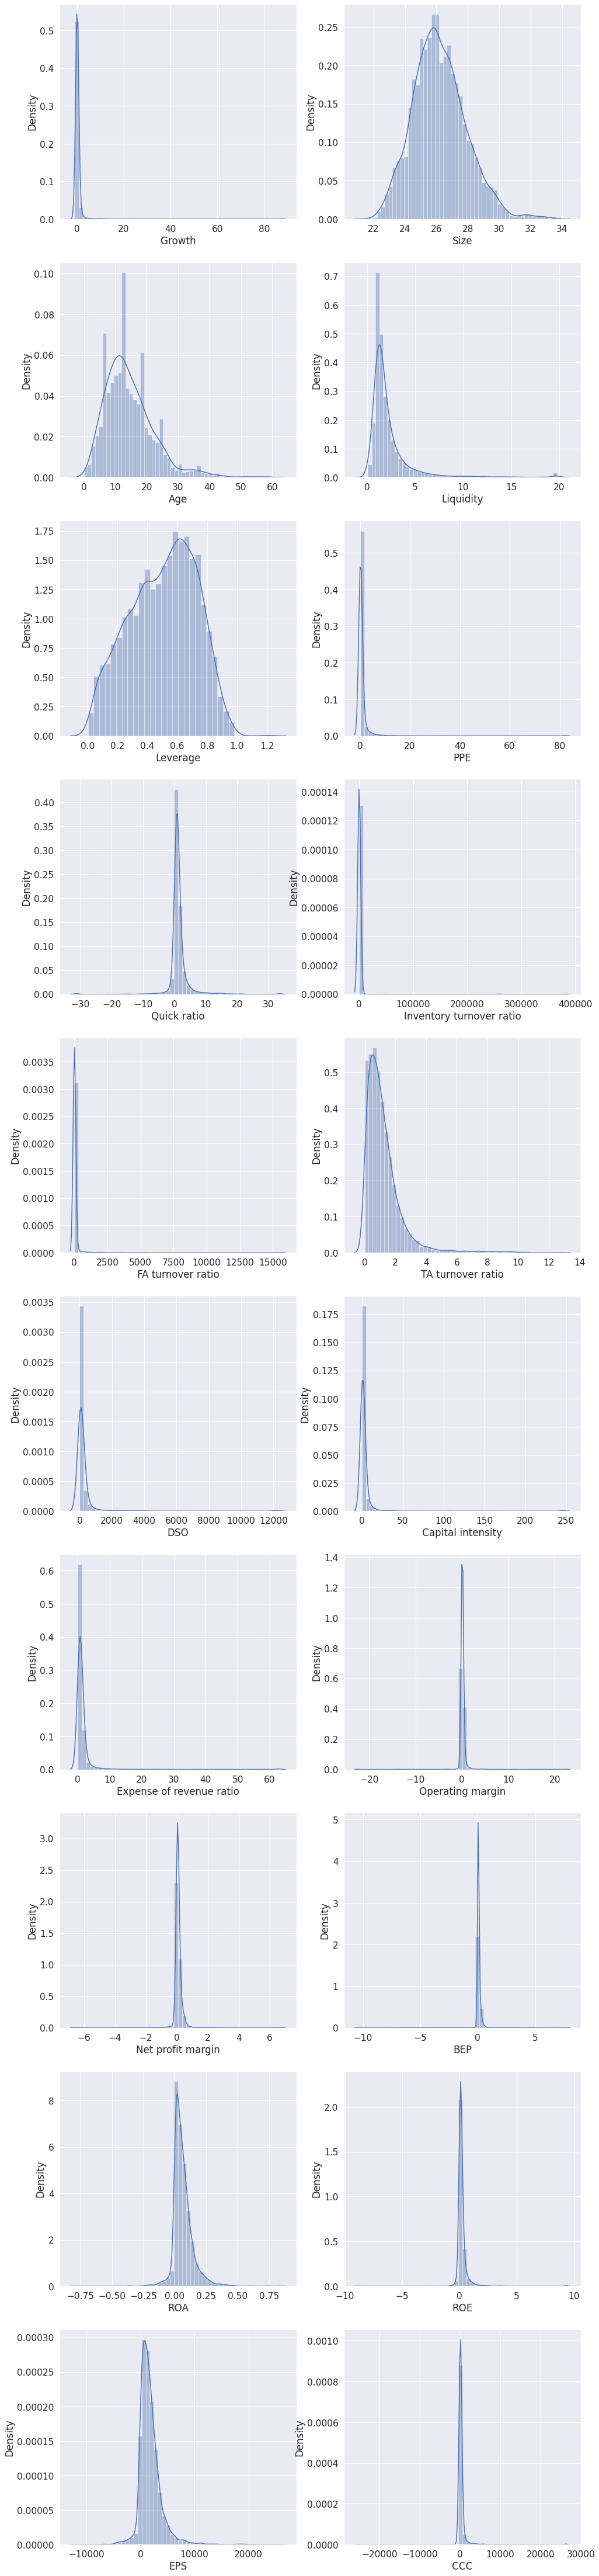

In [64]:

plt.figure(figsize=(16,80))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(10,2,x)
    sns.distplot(data[i])
    x+=1
  plt.show()

density(['Growth', 'Size', 'Age', 'Liquidity', 'Leverage', 'PPE', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'TA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'BEP', 'ROA', 'ROE', 'EPS', 'CCC'])

Có vấn đề: Quick ratio (phải >=0), Operating margin (phải < 1), Net profit margin (phải < 1).

In [65]:
# Check proportion of missing values in each column

(data.isnull().sum()/5676*100).sort_values(axis=0, ascending=False)

Size                        5.761099
Net profit margin           5.056378
ROE                         4.844961
ROA                         4.844961
Growth                      4.474982
EPS                         4.439746
Quick ratio                 4.034531
PPE                         3.488372
Capital intensity           3.312192
TA turnover ratio           3.312192
Operating margin            3.224101
Expense of revenue ratio    3.224101
DSO                         3.224101
FA turnover ratio           3.224101
Leverage                    3.100775
Liquidity                   3.100775
BEP                         3.100775
Inventory turnover ratio    0.775194
CCC                         0.775194
Age                         0.088090
GDP                         0.000000
CPI                         0.000000
Interest rates              0.000000
Target                      0.000000
dtype: float64

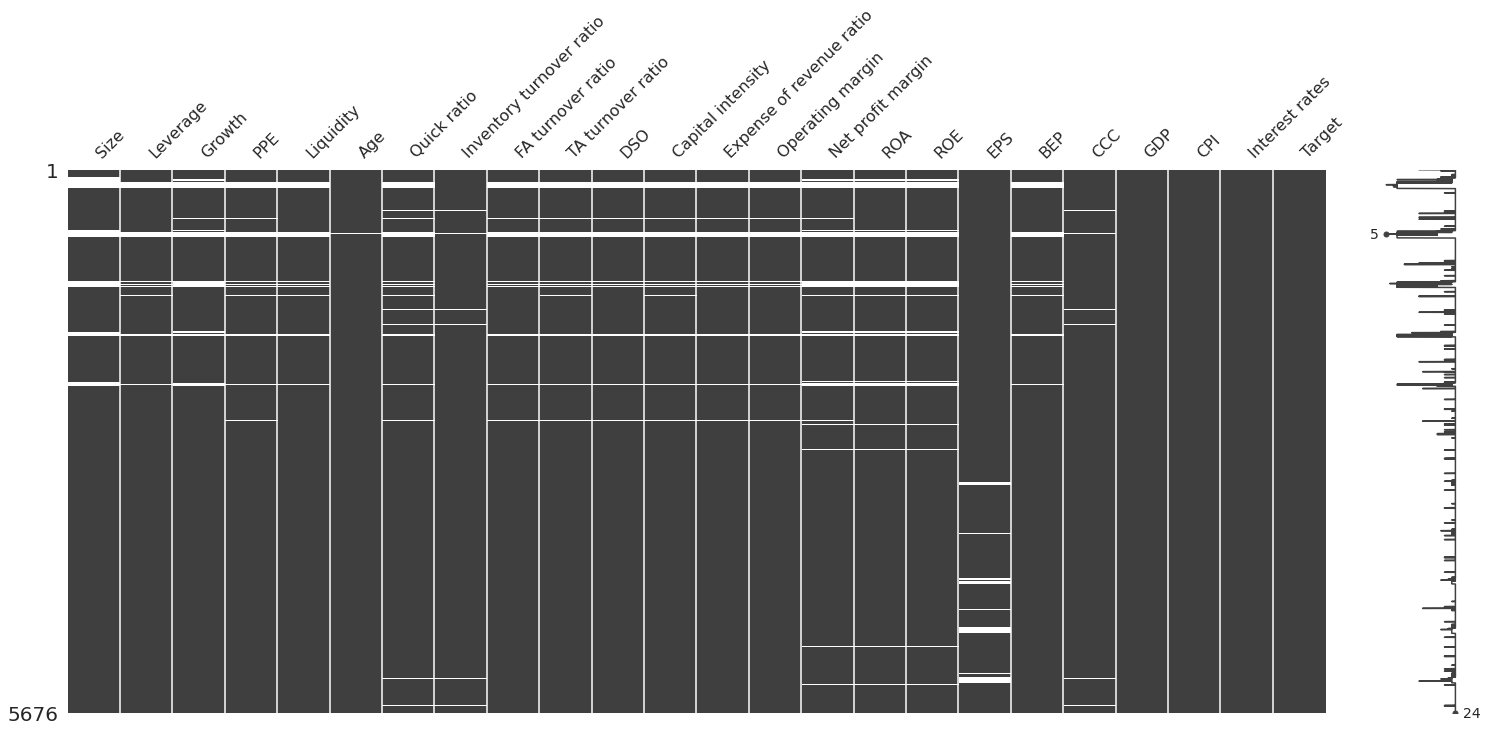

In [66]:
import missingno

missingno.matrix(data)


In [67]:
# Drop rows that have at least 1 NaN
new_data = data.dropna(axis=0)
new_data = new_data.astype({'Age': int})
print(new_data.shape)  # (5002, 24) --> Remains 5002 observations.

print(new_data.isnull().sum().sum()) # Clear all NaNs.

(5002, 24)
0


**Build model**


Split train-test sets

In [68]:

X = new_data.drop('Target', axis=1)
y = new_data.Target

In [69]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

# Scale X
scaler = StandardScaler()
scaler.fit(X)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

Check which algorithm is optimal for this prediction.

In [70]:
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine (Linear Kernel)': LinearSVC(),
    'Support Vector Machine (RBF Kernel)': SVC(),
    'Neural Network': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
}

for name, model in models.items():
  model.fit(X_train, y_train)
  print(name + ' trained.')

Logistic Regression trained.
K-Nearest Neighbors trained.
Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
Support Vector Machine (RBF Kernel) trained.
Neural Network trained.
Random Forest trained.


In [71]:
for name, model in models.items():
  result = model.score(X_test, y_test)
  print(name + ': {:.2f}%'.format(result * 100))

Logistic Regression: 70.93%
K-Nearest Neighbors: 67.93%
Decision Tree: 65.23%
Support Vector Machine (Linear Kernel): 71.83%
Support Vector Machine (RBF Kernel): 71.03%
Neural Network: 70.63%
Random Forest: 72.03%


--> The optimal is Random Forest.

Distribution of target column

In [72]:
# For test set

y_test.value_counts() / len(y_test)

1.0    0.662338
0.0    0.337662
Name: Target, dtype: float64

In [73]:
# For all of dataframe

y.value_counts() / len(y)

1.0    0.660936
0.0    0.339064
Name: Target, dtype: float64

**Build model using Random Forest**




optimal n_estimators value is 81 that accuracy is 0.7113124875124874


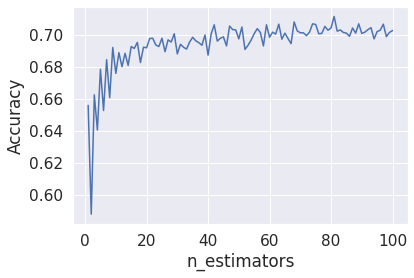

In [74]:

n_estimators = list(range(1, 101))   # 100 trường hợp từ 1 đến 100 Decision Trees để tạo 100 Random Forest Metrics.
param_grid = {
    'n_estimators': n_estimators,
}
rf = RandomForestClassifier()
gs = GridSearchCV(rf, param_grid, cv=5)
gs.fit(X, y)
scores = gs.cv_results_['mean_test_score']

ind = np.where(scores == np.amax(scores))[0][0]+1

print(f'optimal n_estimators value is {ind} that accuracy is {scores.max()}')

import matplotlib.pyplot as plt
plt.plot(n_estimators, scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [75]:
rf = RandomForestClassifier(n_estimators=ind, random_state=0)

**ROC chart**

In [76]:

def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = rf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

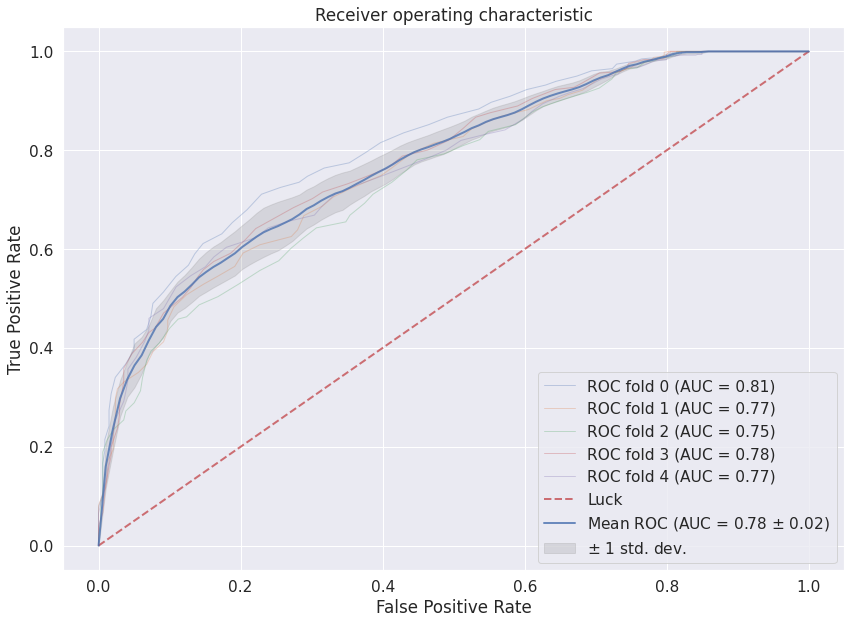

,AUC Train,AUC Test
0,1.0,0.814096
1,1.0,0.771117
2,1.0,0.750427
3,1.0,0.784279
4,1.0,0.774758


In [77]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

**Feature importance**

In [78]:
ft_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(ft_imp)   

ROA                         0.091228
Net profit margin           0.076659
ROE                         0.075502
DSO                         0.056072
Growth                      0.050655
Leverage                    0.048009
CCC                         0.046932
BEP                         0.044795
PPE                         0.044514
Expense of revenue ratio    0.043420
EPS                         0.043049
Inventory turnover ratio    0.040690
Liquidity                   0.039165
Size                        0.039073
Operating margin            0.038694
FA turnover ratio           0.038161
Quick ratio                 0.036344
TA turnover ratio           0.034959
Capital intensity           0.032576
Age                         0.026630
CPI                         0.018323
Interest rates              0.018090
GDP                         0.016460
dtype: float64


**Correlation matrix**

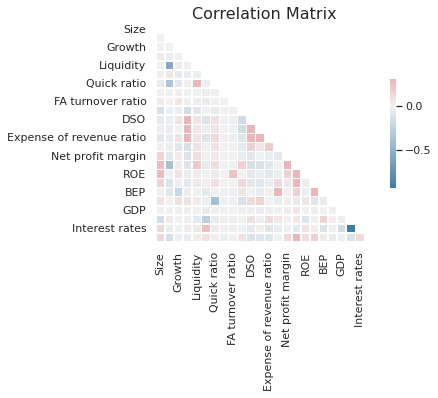

In [79]:
def plot_correlation_matrix(corr_mat):
 sns.set(style="white")
 mask = np.zeros_like(corr_mat, dtype=np.bool)
 mask[np.triu_indices_from(mask)] = True
 fig, ax = plt.subplots()
 cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
 sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
 square=True, linewidths=.5,
 cbar_kws={"shrink": .5}, ax=ax)
 ax.set_title('Correlation Matrix', fontsize=16)
 sns.set(style="darkgrid")
corr_mat = data.select_dtypes(include='number').corr()
plot_correlation_matrix(corr_mat)

**Confusion matrix**

In [80]:
y_pred = rf.predict(X_test)

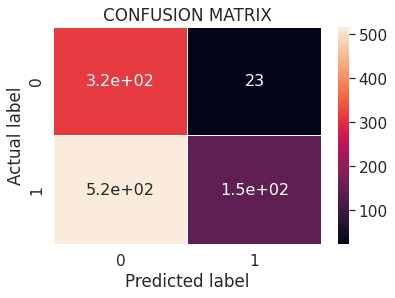

In [81]:
LABELS = [0, 1]
confusion_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16}, linewidths=.5, xticklabels=LABELS, yticklabels=LABELS) # font size
plt.title('CONFUSION MATRIX')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

**Classification report**

In [82]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.38      0.93      0.54       338
         1.0       0.86      0.22      0.35       663

    accuracy                           0.46      1001
   macro avg       0.62      0.58      0.44      1001
weighted avg       0.70      0.46      0.41      1001



The main score at 0.0 target is **recall**. As it appropriates when minimizing false loss is the focus.

The one at 1.0 target is **precision**. Because it appropriates when minimizing false profit is the focus.